# Dendrites and the (passive) cable equation

The cable_equation.passive_cable module implements a passive cable using a Brian2 multicompartment model. The function passive_cable.getting_started() (see below) injects a very short pulse current at (t=500ms, x=100um) into a finite length cable and then lets Brian evolve the dynamics for 2ms. This simulation produces a time x location matrix whose entries are the membrane voltage at each (time,space)-index. The result is visualized using pyplot.imshow.

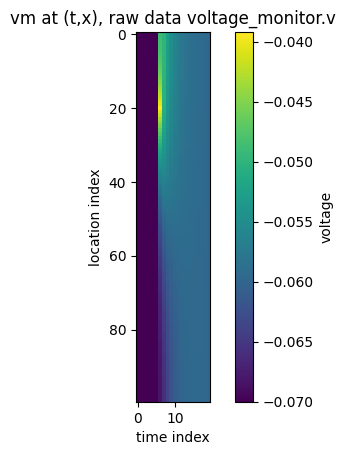

In [26]:
import brian2 as b2
import matplotlib.pyplot as plt
from neurodynex3.cable_equation import passive_cable
from neurodynex3.tools import input_factory
passive_cable.getting_started()

In [2]:
import brian2 as b2
from neurodynex3.tools import input_factory
import matplotlib.pyplot as plt
import numpy as np

# integration time step in milliseconds
b2.defaultclock.dt = 0.01 * b2.ms

# DEFAULT morphological and electrical parameters
CABLE_LENGTH = 500. * b2.um  # length of dendrite
CABLE_DIAMETER = 2. * b2.um  # diameter of dendrite
R_LONGITUDINAL = 0.5 * b2.kohm * b2.mm  # Intracellular medium resistance
R_TRANSVERSAL = 1.25 * b2.Mohm * b2.mm ** 2  # cell membrane resistance (->leak current)
E_LEAK = -70. * b2.mV  # reversal potential of the leak current (-> resting potential)
CAPACITANCE = 0.8 * b2.uF / b2.cm ** 2  # membrane capacitance
DEFAULT_INPUT_CURRENT = input_factory.get_step_current(2000, 3000, unit_time=b2.us, amplitude=0.2 * b2.namp)
DEFAULT_INPUT_LOCATION = [CABLE_LENGTH / 3]  # provide an array of locations
# print("Membrane Timescale = {}".format(R_TRANSVERSAL*CAPACITANCE))


def simulate_passive_cable(current_injection_location=DEFAULT_INPUT_LOCATION, input_current=DEFAULT_INPUT_CURRENT,
                           length=CABLE_LENGTH, diameter=CABLE_DIAMETER,
                           r_longitudinal=R_LONGITUDINAL,
                           r_transversal=R_TRANSVERSAL, e_leak=E_LEAK, initial_voltage=E_LEAK,
                           capacitance=CAPACITANCE, nr_compartments=200, simulation_time=5 * b2.ms):
    """Builds a multicompartment cable and numerically approximates the cable equation.

    Args:
        t_spikes (int): list of spike times
        current_injection_location (list): List [] of input locations (Quantity, Length): [123.*b2.um]
        input_current (TimedArray): TimedArray of current amplitudes. One column per current_injection_location.
        length (Quantity): Length of the cable: 0.8*b2.mm
        diameter (Quantity): Diameter of the cable: 0.2*b2.um
        r_longitudinal (Quantity): The longitudinal (axial) resistance of the cable: 0.5*b2.kohm*b2.mm
        r_transversal (Quantity): The transversal resistance (=membrane resistance): 1.25*b2.Mohm*b2.mm**2
        e_leak (Quantity): The reversal potential of the leak current (=resting potential): -70.*b2.mV
        initial_voltage (Quantity): Value of the potential at t=0: -70.*b2.mV
        capacitance (Quantity): Membrane capacitance: 0.8*b2.uF/b2.cm**2
        nr_compartments (int): Number of compartments. Spatial discretization: 200
        simulation_time (Quantity): Time for which the dynamics are simulated: 5*b2.ms

    Returns:
        (StateMonitor, SpatialNeuron): The state monitor contains the membrane voltage in a
        Time x Location matrix. The SpatialNeuron object specifies the simulated neuron model
        and gives access to the morphology. You may want to use those objects for
        spatial indexing: myVoltageStateMonitor[mySpatialNeuron.morphology[0.123*b2.um]].v
    """
    assert isinstance(input_current, b2.TimedArray), "input_current is not of type TimedArray"
    assert input_current.values.shape[1] == len(current_injection_location),\
        "number of injection_locations does not match nr of input currents"

    cable_morphology = b2.Cylinder(diameter=diameter, length=length, n=nr_compartments)
    # Im is transmembrane current
    # Iext is  injected current at a specific position on dendrite
    EL = e_leak
    RT = r_transversal
    eqs = """
    Iext = current(t, location_index): amp (point current)
    location_index : integer (constant)
    Im = (EL-v)/RT : amp/meter**2
    """
    cable_model = b2.SpatialNeuron(morphology=cable_morphology, model=eqs, Cm=capacitance, Ri=r_longitudinal)
    monitor_v = b2.StateMonitor(cable_model, "v", record=True)

    # inject all input currents at the specified location:
    nr_input_locations = len(current_injection_location)
    input_current_0 = np.insert(input_current.values, 0, 0., axis=1) * b2.amp  # insert default current: 0. [amp]
    current = b2.TimedArray(input_current_0, dt=input_current.dt * b2.second)
    for current_index in range(nr_input_locations):
        insert_location = current_injection_location[current_index]
        compartment_index = int(np.floor(insert_location / (length / nr_compartments)))
        # next line: current_index+1 because 0 is the default current 0Amp
        cable_model.location_index[compartment_index] = current_index + 1

    # set initial values and run for 1 ms
    cable_model.v = initial_voltage
    b2.run(simulation_time)
    return monitor_v, cable_model

In [27]:
from neurodynex3.cable_equation import passive_cable
print(passive_cable.R_TRANSVERSAL)


1.25 m^4 kg s^-3 A^-2


***4.1 exercise: spatial and temporal evolution of a pulse input***

Create a cable of length 800um and inject a 0.1ms long step current of amplitude 0.8nA at (t=1ms, x=200um). Run Brian for 3ms.

***Questions***

1. What is the maximum depolarization you observe? Where and when does it occur?
2. Plot the temporal evolution (t in [0ms, 3ms]) of the membrane voltage at the locations 0um, 100um, … , 600 um in one figure.
3. Plot the spatial evolution (x in [0um, 800um]) of the membrane voltage at the time points 1.0ms, 1.1ms, … , 1.6ms in one plot
4. Discuss the figures.

*What is the maximum depolarization you observe? Where and when does it occur?*

The maximum depolarization seems to be over 10 000 mV. It occurs at the start of the stimulation (I would say around 3 ms) and at approximately 250 um from the start of the cable. 

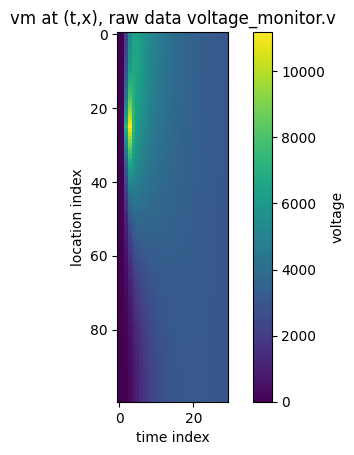

In [28]:
import brian2 as b2
import matplotlib.pyplot as plt
from neurodynex3.cable_equation import passive_cable
from neurodynex3.tools import input_factory


# length = 800 um 
# 0.1 ms step current 0.8 nA at t = 1 ms and x = 200 um
# run for 3 s

current = input_factory.get_step_current(1, 2, 0.1*b2.ms, 800000*b2.nA)

voltage_monitor, cable_model = passive_cable.simulate_passive_cable(
        length=0.8 * b2.mm, current_injection_location=[200. * b2.um], input_current=current,
        nr_compartments=100, simulation_time=3 * b2.ms)

plt.figure()
plt.imshow(voltage_monitor.v / b2.volt)
plt.colorbar(label="voltage")
plt.xlabel("time index")
plt.ylabel("location index")
plt.title("vm at (t,x), raw data voltage_monitor.v")
plt.show()

*Plot the temporal evolution (t in [0ms, 3ms]) of the membrane voltage at the locations 0um, 100um, … , 600 um in one figure.*

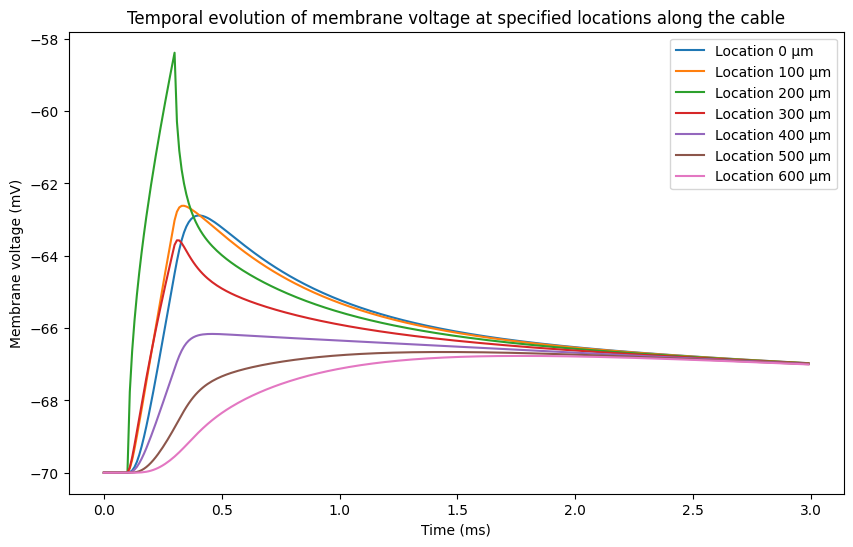

In [47]:
# plot the temporal evolution 
# state monitor contains the membrane voltage in a TxLoc. matrix 

import brian2 as b2
import matplotlib.pyplot as plt
from neurodynex3.cable_equation import passive_cable
from neurodynex3.tools import input_factory


current = input_factory.get_step_current(1, 2, 0.1 * b2.ms, 0.8 * b2.nA)


voltage_monitor, cable_model = passive_cable.simulate_passive_cable(
    length=0.8 * b2.mm,
    current_injection_location=[200. * b2.um],
    input_current=current,
    nr_compartments=100,
    simulation_time=3 * b2.ms
)

locations_um = [0, 100, 200, 300, 400, 500, 600]


total_length = 0.8 * b2.mm
nr_compartments = 100
compartment_length = total_length / nr_compartments  


location_indices = [int((loc * b2.um) / compartment_length) for loc in locations_um]


plt.figure(figsize=(10, 6))
time = voltage_monitor.t / b2.ms  

for idx, loc in zip(location_indices, locations_um): #zips the two lists together
    plt.plot(time, voltage_monitor.v[idx] / b2.mV, label=f'Location {loc} µm')


plt.xlabel("Time (ms)")
plt.ylabel("Membrane voltage (mV)")
plt.title("Temporal evolution of membrane voltage at specified locations along the cable")
plt.legend()
plt.show()


*Plot the spatial evolution (x in [0um, 800um]) of the membrane voltage at the time points 1.0ms, 1.1ms, … , 1.6ms in one plot*

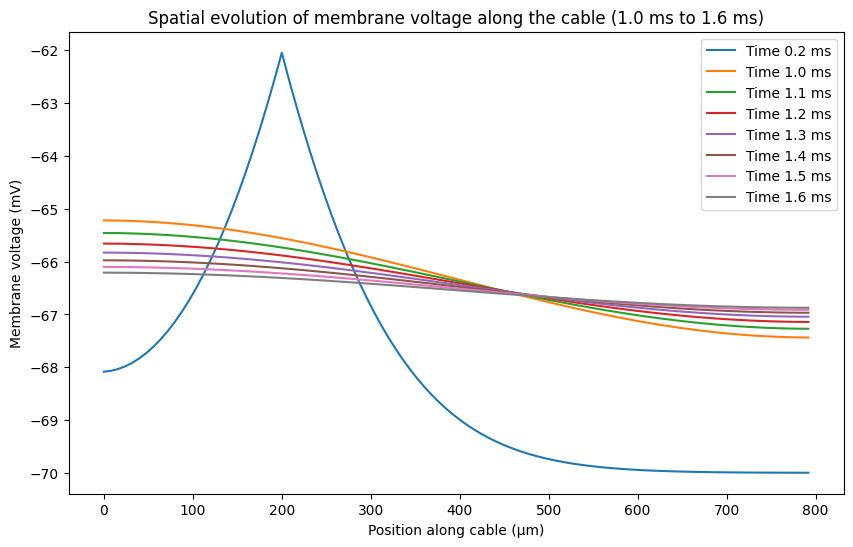

In [14]:
import brian2 as b2
import matplotlib.pyplot as plt
from neurodynex3.cable_equation import passive_cable
from neurodynex3.tools import input_factory
import numpy as np


current = input_factory.get_step_current(1, 2, 0.1 * b2.ms, 0.8 * b2.nA)

voltage_monitor, cable_model = passive_cable.simulate_passive_cable(
    length=0.8 * b2.mm,
    current_injection_location=[200. * b2.um],
    input_current=current,
    nr_compartments=100,
    simulation_time=3 * b2.ms
)

spatial_positions_um = [i * 800 / 100 for i in range(100)]  #divide 0 to 800 µm into 100 compartments

time_points = [0.2] + [1.0 + 0.1 * i for i in range(7)] 
time_points *= b2.ms

#find the nearest index for each specified time point
time_indices = [np.searchsorted(time_array, time_point / b2.ms) for time_point in time_points]

#plot the spatial evolution of membrane voltage at each chosen time
plt.figure(figsize=(10, 6))

for t_idx, time in zip(time_indices, time_points):
    plt.plot(spatial_positions_um, voltage_monitor.v[:, t_idx] / b2.mV, label=f'Time {time / b2.ms:.1f} ms')

plt.xlabel("Position along cable (µm)")
plt.ylabel("Membrane voltage (mV)")
plt.title("Spatial evolution of membrane voltage along the cable (1.0 ms to 1.6 ms)")
plt.legend()
plt.show()


*Discuss the figures.*

In the temporal evolution, the membrane voltage peaks around 200 um; where we injected the current. Over time, as the action potential spreads throughout the axon we see that the charge spreads throughout the cable, and the locations closest to the injection site experience an increase, albeit a smaller one, of their membrane voltage. This is caused by axial resistance along the cable/axon and leak currents. 

In the spatial evolution plot, the membrane voltage again peaks at 200 um upon injection (0.2 ms here). Furthermore, as the action potentials spread along the cable, we see a higher membrane voltage at positions close to the injection site for early timepoints and a lower membrane voltage for those far away from the injection site. However, as time progresses, this turns around: positions far away from the injection site have a higher membrane voltage for later timepoints. 

***4.2 exercise: spatio-temporal input pattern***

While the passive cable used here is a very simplified model of a real dendrite, we can still get an idea of how input spikes would look to the soma. Imagine a dendrite of some length and the soma at x=0um. What is the depolarization at x=0 if the dendrite receives multiple spikes at different time/space locations?

Create a cable of length 800uM and inject three short pulses A, B, and C at different time/space locations:
A: (t=1.0ms, x=100um)
B: (t=1.5ms, x=200um)
C: (t=2.0ms, x=300um)
Pulse input: 100us duration, 0.8nA amplitude. 

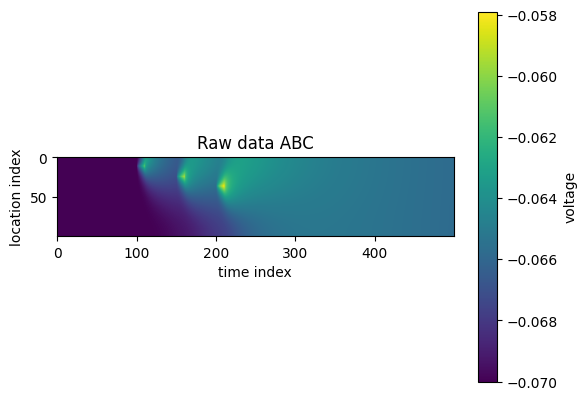

In [37]:
t_spikes = [10, 15, 20]
l_spikes = [100. * b2.um, 200. * b2.um, 300. * b2.um]
current = input_factory.get_spikes_current(t_spikes, 100*b2.us, 0.8*b2.namp, append_zero=True)

voltage_monitor_ABC, cable_model = passive_cable.simulate_passive_cable(
    current_injection_location=l_spikes, 
    input_current=current, 
    length=0.8 * b2.mm, 
    nr_compartments=100,
    simulation_time=5 * b2.ms)

plt.figure()
plt.imshow(voltage_monitor_ABC.v / b2.volt)
plt.colorbar(label="voltage")
plt.xlabel("time index")
plt.ylabel("location index")
plt.title("Raw data ABC")
plt.show()

*Reverse the order of the input spikes*

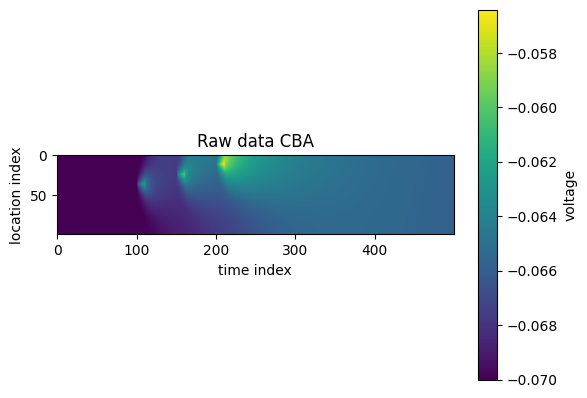

In [39]:
t_spikes = [10, 15, 20]
l_spikes = [300. * b2.um, 200. * b2.um, 100. * b2.um]
current = input_factory.get_spikes_current(t_spikes, 100*b2.us, 0.8*b2.namp, append_zero=True)

voltage_monitor_ABC, cable_model = passive_cable.simulate_passive_cable(
    current_injection_location=l_spikes, 
    input_current=current, 
    length=0.8 * b2.mm, 
    nr_compartments=100,
    simulation_time=5 * b2.ms)

plt.figure()
plt.imshow(voltage_monitor_ABC.v / b2.volt)
plt.colorbar(label="voltage")
plt.xlabel("time index")
plt.ylabel("location index")
plt.title("Raw data CBA")
plt.show()

*Plot the temporal evolution of the membrane voltage at the soma (x=0)*

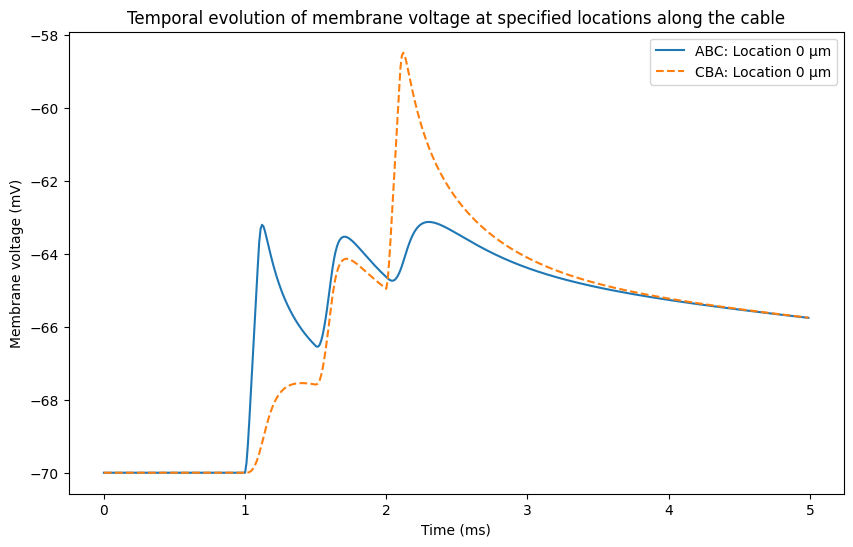

In [51]:
# plot the temporal evolution 
# state monitor contains the membrane voltage in a TxLoc. matrix 

import brian2 as b2
import matplotlib.pyplot as plt
from neurodynex3.cable_equation import passive_cable
from neurodynex3.tools import input_factory


t_spikes_ABC = [10, 15, 20]
l_spikes_ABC = [100. * b2.um, 200. * b2.um, 300. * b2.um]
current = input_factory.get_spikes_current(t_spikes_ABC, 100*b2.us, 0.8*b2.namp, append_zero=True)

voltage_monitor_ABC, cable_model = passive_cable.simulate_passive_cable(
    current_injection_location=l_spikes_ABC, 
    input_current=current, 
    length=0.8 * b2.mm, 
    nr_compartments=100,
    simulation_time=5 * b2.ms)


t_spikes_CBA = [10, 15, 20]
l_spikes_CBA = [300. * b2.um, 200. * b2.um, 100. * b2.um]
current = input_factory.get_spikes_current(t_spikes_CBA, 100*b2.us, 0.8*b2.namp, append_zero=True)

voltage_monitor_CBA, cable_model = passive_cable.simulate_passive_cable(
    current_injection_location=l_spikes_CBA, 
    input_current=current, 
    length=0.8 * b2.mm, 
    nr_compartments=100,
    simulation_time=5 * b2.ms)

locations_um = [0]


total_length = 0.8 * b2.mm
nr_compartments = 100
compartment_length = total_length / nr_compartments  


location_indices = [int((loc * b2.um) / compartment_length) for loc in locations_um]


plt.figure(figsize=(10, 6))
time = voltage_monitor_ABC.t / b2.ms  

for idx, loc in zip(location_indices, locations_um): #zips the two lists together
    plt.plot(time, voltage_monitor_ABC.v[idx] / b2.mV, linestyle='-', label=f'ABC: Location {loc} µm')
    plt.plot(time, voltage_monitor_CBA.v[idx] / b2.mV, linestyle='--', label=f'CBA: Location {loc} µm')

plt.xlabel("Time (ms)")
plt.ylabel("Membrane voltage (mV)")
plt.title("Temporal evolution of membrane voltage at specified locations along the cable")
plt.legend()
plt.show()


The maximal depolarization of the soma (x=0) is higher for the CBA stimulation pattern. Below, I have adapted a figure from the literature to visualize the different stimulation patterns: 

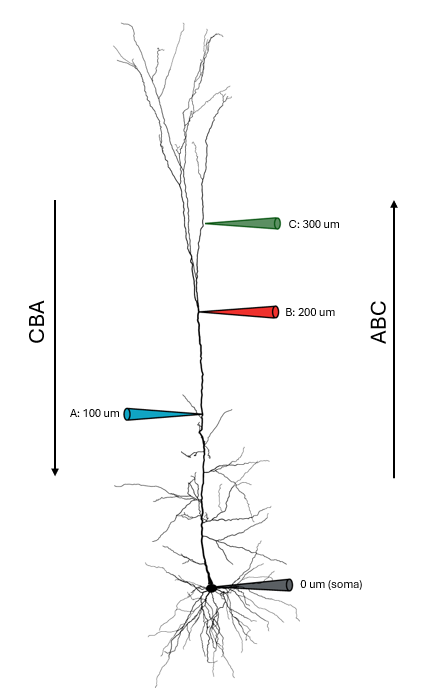
*Figure adapted from Hay, E., Hill, S., Schürmann, F., Markram, H., & Segev, I. (2011). Models of Neocortical Layer 5b Pyramidal Cells Capturing a Wide Range of Dendritic and Perisomatic Active Properties. PLoS Computational Biology, 7(7), e1002107. https://doi.org/10.1371/journal.pcbi.1002107*

Let's compare situation ABC and CBA. When stimulating according to pattern ABC, each pulse will separately arrive at the soma: While location B is being stimulated, the pulse from location A will have already arrived at the soma and the membrane voltage at 0 um will have already started to decrease (same for the stimulation of location C). For stimulation pattern CBA, location C will be stimulated first and its charge will propagate towards the soma; since this location is further away, it will take longer to arrive at the soma, leaving the soma depolarized at a later timepoint compared to stimulation pattern ABC. This causes the subsequent inputs at location A and location B to add onto the elevated membrane potential, causing the maximum membrane voltage at the soma to be higher for pattern CBA. 

***Exercise: Effect of cable parameters***

Inject a very brief pulse current at (t=.05ms, x=400um). Run Brian twice for 0.2 ms with two different parameter sets. Plot the temporal evolution of the membrane voltage at x=500um for the two parameter sets:

**set 1**: (same as defaults)

membrane_resistance_1 = 1.25 * b2.Mohm * b2.mm ** 2

membrane_capacitance_1 = 0.8 * b2.uF / b2.cm ** 2

**set 2**: (you can think of a myelinated "cable")

membrane_resistance_2 = 5.0 * b2.Mohm * b2.mm ** 2

membrane_capacitance_2 = 0.2 * b2.uF / b2.cm ** 2

 Discuss your observations.

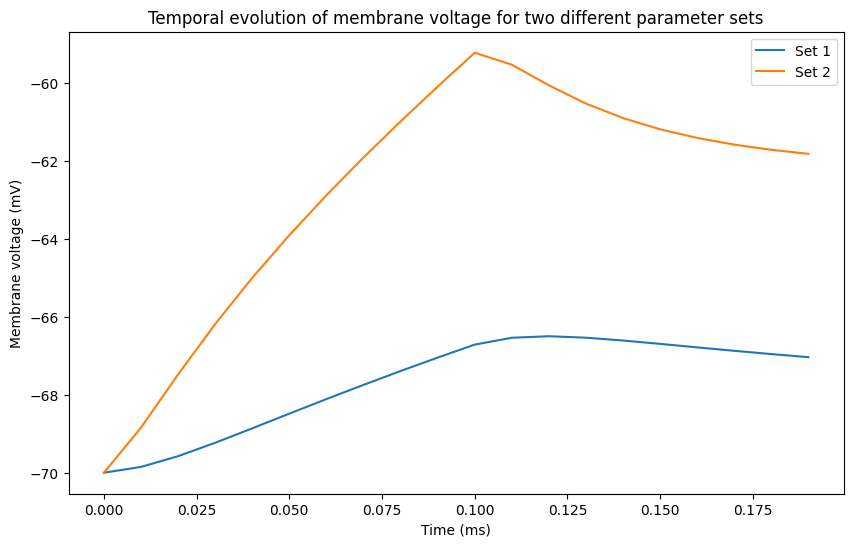

In [54]:
# plot the temporal evolution 


import brian2 as b2
import matplotlib.pyplot as plt
from neurodynex3.cable_equation import passive_cable
from neurodynex3.tools import input_factory

current = input_factory.get_step_current(int(0.05), int(0.1), 0.1 * b2.ms, 0.8 * b2.nA)


voltage_monitor_1, cable_model = passive_cable.simulate_passive_cable(
    length=0.8 * b2.mm,
    current_injection_location=[400. * b2.um],
    input_current=current,
    nr_compartments=100,
    simulation_time=0.2 * b2.ms
)

voltage_monitor_2, cable_model = passive_cable.simulate_passive_cable(
    length=0.8 * b2.mm,
    current_injection_location=[400. * b2.um],
    input_current=current,
    nr_compartments=100,
    simulation_time=0.2 * b2.ms, 
    r_transversal = 5.0 * b2.Mohm * b2.mm ** 2, 
    capacitance = 0.2 * b2.uF / b2.cm ** 2
)

# Define the locations in micrometers
locations_um = [500]

# Convert locations to compartment indices
total_length = 0.8 * b2.mm
nr_compartments = 100
compartment_length = total_length / nr_compartments  # Length of each compartment in meters

# Convert locations in micrometers to indices
location_indices = [int((loc * b2.um) / compartment_length) for loc in locations_um]

# Plot the temporal evolution of the membrane voltage for the specified locations
plt.figure(figsize=(10, 6))
time = voltage_monitor_1.t / b2.ms  # Time array in ms

for idx, loc in zip(location_indices, locations_um):
    plt.plot(time, voltage_monitor_1.v[idx] / b2.mV, label=f'Set 1')
    plt.plot(time, voltage_monitor_2.v[idx] / b2.mV, label=f'Set 2')

# Labels and legend
plt.xlabel("Time (ms)")
plt.ylabel("Membrane voltage (mV)")
plt.title("Temporal evolution of membrane voltage for two different parameter sets")
plt.legend()
plt.show()


The second set, representing a myelinated cable, attains a higher membrane voltage than the unmyelinated cable. Myelinated axons have sodium and potassium channels only in restricted segments called nodes of Ranvier. Ions are trapped by myelin since it prevents them to either flow outside the axon or accumulate on the membrane. Instead, ions flow in and out of the the nodes such that an ion leaving a node of Ranvier forces another to enter the following node. This improves the speed of the electrical transmission along the axon. Furthermore, the increased resistance and decreased capacitance of the myelinated axon allow it to 1) leak less current  and 2) faster accumulate charge (respectively) *Bakiri, Y., Káradóttir, R., Cossell, L., & Attwell, D. (2011). Morphological and electrical properties of oligodendrocytes in the white matter of the corpus callosum and cerebellum. The Journal of Physiology, 589(3), 559-573. https://doi.org/10.1113/jphysiol.2010.201376*. 
 

***Exercise***: stationary solution and comparison with theoretical result 

Create a cable of length 500um and inject a constant current of amplitude 0.1 nA at x=0um i.e. ∂u(t,x)/∂t=0. The (partial differential) cable equation then reduces to: 

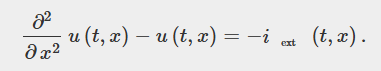

Upon the injection of a localized input current at x = 0 (as we do here), the solution to this equation is: 

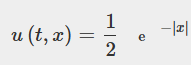

This solution is given in units of the intrinsic length scale λ: 

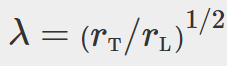

λ is the length over which the stationary membrane potential drops by a factor 1/e (about 37%). 


1. Plot Vm vs. time (t in [0ms, 100ms]) at x=0um and x=500um.
2. Plot Vm vs location (x in [0um, 500um]) at t=100ms.

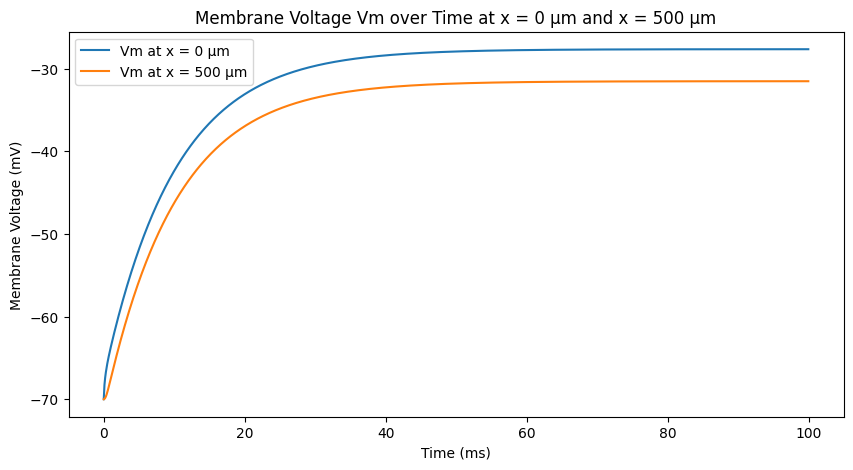

In [58]:
import brian2 as b2
import matplotlib.pyplot as plt
from neurodynex3.cable_equation import passive_cable
from neurodynex3.tools import input_factory

b2.defaultclock.dt = 0.1 * b2.ms

current = input_factory.get_step_current(0, 0, unit_time=b2.ms, amplitude=0.1 * b2.namp, append_zero=False)

sim_time = 100*b2.ms
N_comp = 100

voltage_monitor, cable_model = passive_cable.simulate_passive_cable(
length=0.5 * b2.mm, current_injection_location = [0*b2.um],
input_current=current, simulation_time=sim_time, nr_compartments=N_comp)

v_X0 = voltage_monitor.v[0,:]  # access the first compartment
v_Xend = voltage_monitor.v[-1,:]  # access the last compartment
v_Tend = voltage_monitor.v[:, -1]  # access the last time step

# plot Vm vs. Time for x = 0 um and x = 500 um
plt.figure(figsize=(10, 5))

# plot Vm at x = 0 um
plt.plot(voltage_monitor.t / b2.ms, v_X0 / b2.mV, label="Vm at x = 0 µm")

# plot Vm at x = 500 um
plt.plot(voltage_monitor.t / b2.ms, v_Xend / b2.mV, label="Vm at x = 500 µm")

plt.xlabel("Time (ms)")
plt.ylabel("Membrane Voltage (mV)")
plt.title("Membrane Voltage Vm over Time at x = 0 µm and x = 500 µm")
plt.legend()
plt.show()



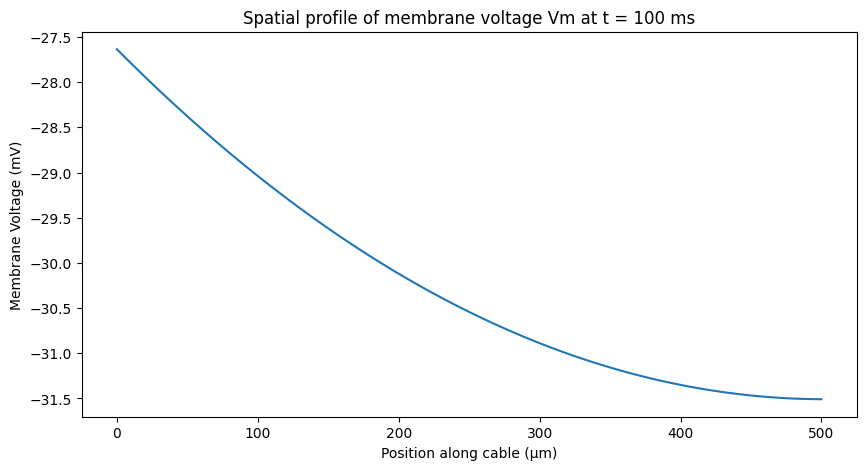

In [56]:
import brian2 as b2
import matplotlib.pyplot as plt
from neurodynex3.cable_equation import passive_cable
from neurodynex3.tools import input_factory
import numpy as np


b2.defaultclock.dt = 0.1 * b2.ms
current = input_factory.get_step_current(0, 0, unit_time=b2.ms, amplitude=0.1 * b2.namp, append_zero=False)
sim_time = 100 * b2.ms
N_comp = 100


voltage_monitor, cable_model = passive_cable.simulate_passive_cable(
    length=0.5 * b2.mm,
    current_injection_location=[0 * b2.um],
    input_current=current,
    simulation_time=sim_time,
    nr_compartments=N_comp
)

#define spatial positions along the cable
spatial_positions_um = np.linspace(0, 500, N_comp)  # Positions from 0 to 500 µm

#find the index closest to t = 100 ms and ensure it's within bounds
target_time = 100 * b2.ms
time_index = min(np.searchsorted(np.array(voltage_monitor.t), target_time), len(voltage_monitor.t) - 1)

#extract Vm across all compartments at t = 100 ms
vm_at_100ms = voltage_monitor.v[:, time_index] / b2.mV  # Convert to mV for easier plotting

plt.figure(figsize=(10, 5))
plt.plot(spatial_positions_um, vm_at_100ms)
plt.xlabel("Position along cable (µm)")
plt.ylabel("Membrane Voltage (mV)")
plt.title("Spatial profile of membrane voltage Vm at t = 100 ms")
plt.show()


In [23]:
#compute the length constant lamda of the cable 

import brian2 as b2
import matplotlib.pyplot as plt
from neurodynex3.cable_equation import passive_cable
from neurodynex3.tools import input_factory
import numpy as np

#from neurodynex3.cable_equation import passive_cable
#print(passive_cable.R_TRANSVERSAL)

R_m = passive_cable.R_TRANSVERSAL #membrane resistance
R_l = passive_cable.R_LONGITUDINAL #longitudinal resistance
# Calculate the length constant

lambda_ = b2.sqrt(R_m / R_l)
print(f"Length constant (lambda): {lambda_:.2f}")

Length constant (lambda): 1.58


*Compute the characteristic length λ (= length scale = lenght constant) of the cable.*

The length constant describes how quickly the membrane voltage decreases exponentially with distance from the site of current injection (*Ilmoniemi, R. J., Mäki, H., Saari, J., Salvador, R., & Miranda, P. C. (2016). The Frequency-Dependent Neuronal Length Constant in Transcranial Magnetic Stimulation. Frontiers in Cellular Neuroscience, 10. https://doi.org/10.3389/fncel.2016.00194*). Relating this to our plots above; we see that the steady state that is reached upon stationary stimulation of the axon at location x = 0 is lower further away from the injection site. If we were to have a higher length constant, this final steady state voltage would be even lower further away from the injection site: 

In [60]:
R_LONGITUDINAL = 0.5 * b2.kohm * b2.mm  # Intracellular medium resistance
R_TRANSVERSAL = 1.25 * b2.Mohm * b2.mm ** 2  # cell membrane resistance (->leak current)

<module 'neurodynex3.cable_equation.passive_cable' from 'c:\\Users\\emmac\\anaconda3\\envs\\bmnn\\Lib\\site-packages\\neurodynex3\\cable_equation\\passive_cable.py'>


Lambda_1: 2.23606798 m^0.5
Lambda_2: 1.58113883 m^0.5


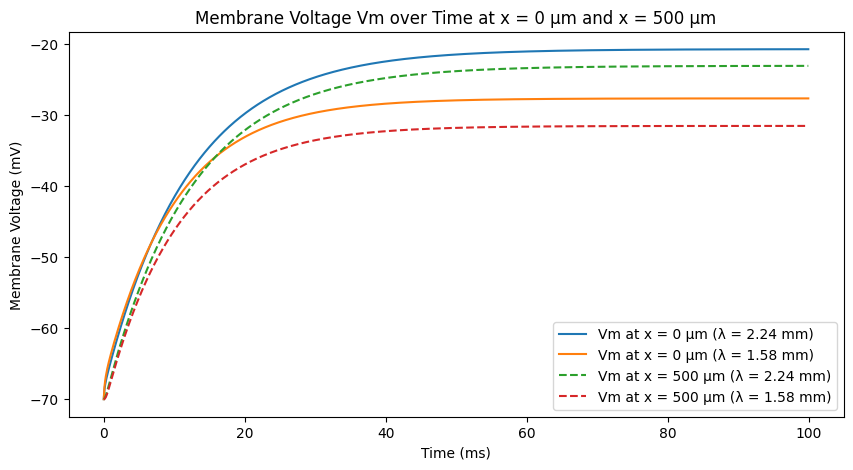

In [ ]:
import brian2 as b2
import matplotlib.pyplot as plt
from neurodynex3.cable_equation import passive_cable
from neurodynex3.tools import input_factory

b2.defaultclock.dt = 0.1 * b2.ms

current = input_factory.get_step_current(0, 0, unit_time=b2.ms, amplitude=0.1 * b2.namp, append_zero=False)

sim_time = 100 * b2.ms
N_comp = 100

r_longitudinal_1 = 0.3 * b2.kohm * b2.mm
r_transversal_1 = 1.5 * b2.Mohm * b2.mm ** 2

voltage_monitor_1, cable_model_1 = passive_cable.simulate_passive_cable(
    length=0.5 * b2.mm, 
    current_injection_location=[0 * b2.um],
    input_current=current, 
    simulation_time=sim_time, 
    nr_compartments=N_comp, 
    r_longitudinal=r_longitudinal_1, 
    r_transversal=r_transversal_1
)

v_X0_1 = voltage_monitor_1.v[0, :]
v_Xend_1 = voltage_monitor_1.v[-1, :]

lambda_1 = b2.sqrt(r_transversal_1 / r_longitudinal_1)
print(f"Lambda_1: {lambda_1}")

voltage_monitor_2, cable_model_2 = passive_cable.simulate_passive_cable(
    length=0.5 * b2.mm, 
    current_injection_location=[0 * b2.um],
    input_current=current, 
    simulation_time=sim_time, 
    nr_compartments=N_comp
)

v_X0_2 = voltage_monitor_2.v[0, :]
v_Xend_2 = voltage_monitor_2.v[-1, :]

lambda_2 = b2.sqrt(passive_cable.R_TRANSVERSAL / passive_cable.R_LONGITUDINAL)
print(f"Lambda_2: {lambda_2}")

plt.figure(figsize=(10, 5))

plt.plot(
    voltage_monitor_1.t / b2.ms, v_X0_1 / b2.mV, 
    label=f"Vm at x = 0 µm (λ = {lambda_1:.2f} mm)")
plt.plot(
    voltage_monitor_2.t / b2.ms, v_X0_2 / b2.mV, 
    label=f"Vm at x = 0 µm (λ = {lambda_2:.2f} mm)")

plt.plot(
    voltage_monitor_1.t / b2.ms, v_Xend_1 / b2.mV, 
    label=f"Vm at x = 500 µm (λ = {lambda   _1:.2f} mm)", linestyle="dashed")
plt.plot(
    voltage_monitor_2.t / b2.ms, v_Xend_2 / b2.mV, 
    label=f"Vm at x = 500 µm (λ = {lambda_2:.2f} mm)", linestyle="dashed")

plt.xlabel("Time (ms)")
plt.ylabel("Membrane Voltage (mV)")
plt.title("Membrane Voltage Vm over Time at x = 0 µm and x = 500 µm")
plt.legend()
plt.show()
